In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from src.gmm import GMM
import src.utils as utils

### Without outliers

In [2]:
df = pd.read_csv("data/diamonds.csv")
X_train, X_test, y_train, y_test = utils.preprocessing_LOS(df)

First we search for the best `covariance_type` and `init_params` parameters, with a fixed `n_components` to 5.

In [3]:
param_grid = {
	"covariance_type": ["full", "tied", "diag", "spherical"],
	"init_params": ["kmeans", "random", "random_from_data"],
}

grid_search = GridSearchCV(GMM(n_components=5, max_iter=200, n_init=5), param_grid, cv=5, scoring="accuracy",
							   return_train_score=True, verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=<src.gmm.GMM object at 0x000001A9E3BD82B0>,
             n_jobs=-1,
             param_grid={'covariance_type': ['full', 'tied', 'diag',
                                             'spherical'],
                         'init_params': ['kmeans', 'random',
                                         'random_from_data']},
             return_train_score=True, scoring='accuracy', verbose=10)

In [4]:
sorted(zip(grid_search.cv_results_["mean_test_score"], grid_search.cv_results_["params"]), reverse=True, key=lambda x: x[0])

[(0.6792388105331524, {'covariance_type': 'full', 'init_params': 'random'}),
 (0.6722848610236447,
  {'covariance_type': 'full', 'init_params': 'random_from_data'}),
 (0.6712495086623358, {'covariance_type': 'full', 'init_params': 'kmeans'}),
 (0.6304543869585247, {'covariance_type': 'tied', 'init_params': 'kmeans'}),
 (0.6027180306481994, {'covariance_type': 'tied', 'init_params': 'random'}),
 (0.6013643478346626,
  {'covariance_type': 'tied', 'init_params': 'random_from_data'}),
 (0.583342385217182,
  {'covariance_type': 'spherical', 'init_params': 'random_from_data'}),
 (0.5795731349949352,
  {'covariance_type': 'spherical', 'init_params': 'random'}),
 (0.5794669320946693,
  {'covariance_type': 'spherical', 'init_params': 'kmeans'}),
 (0.5365217977816192, {'covariance_type': 'diag', 'init_params': 'kmeans'}),
 (0.5358318364264713, {'covariance_type': 'diag', 'init_params': 'random'}),
 (0.5242062624947696,
  {'covariance_type': 'diag', 'init_params': 'random_from_data'})]

Once found the best values for these two parameters, we search for the best `n_components`.

In [5]:
param_grid = {
	"n_components": [1, 5, 10, 15, 20]
}

grid_search = GridSearchCV(GMM(covariance_type="full",max_iter=200, n_init=5, init_params="random"),
									param_grid, cv=5, scoring="accuracy",
									return_train_score=True, verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=<src.gmm.GMM object at 0x000001A9E3383BB0>,
             n_jobs=-1, param_grid={'n_components': [1, 5, 10, 15, 20]},
             return_train_score=True, scoring='accuracy', verbose=10)

In [6]:
sorted(zip(grid_search.cv_results_["mean_test_score"], grid_search.cv_results_["params"]), reverse=True, key=lambda x: x[0])

[(0.7077716199138627, {'n_components': 10}),
 (0.7053294991384862, {'n_components': 15}),
 (0.683910406778276, {'n_components': 20}),
 (0.6792388105331524, {'n_components': 5}),
 (0.6027180306481994, {'n_components': 1})]

The optimal value is between 10 and 15. As the difference is too small, we will take 10 that is less computationally expensive.

In [3]:
model = GMM(n_components=10, max_iter=200, n_init=5, covariance_type="full", init_params="random")
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model.fit(X_train2, y_train2)
model.compute_metrics(X_val, y_val)

{'accuracy': 0.6834609700389628,
 'precision': 0.5784134935076226,
 'recall': 0.6562584701050727,
 'f1': 0.6058427017427499}

The model achieves a high recall but a low precision.

In [4]:
result_df = pd.DataFrame({"y_val": y_val, "y_pred": model.predict(X_val)})
result_counts = result_df.apply(pd.Series.value_counts)
result_counts

,y_val,y_pred
4,3231,2862
3,1837,1838
2,1765,1774
1,567,901
0,43,68


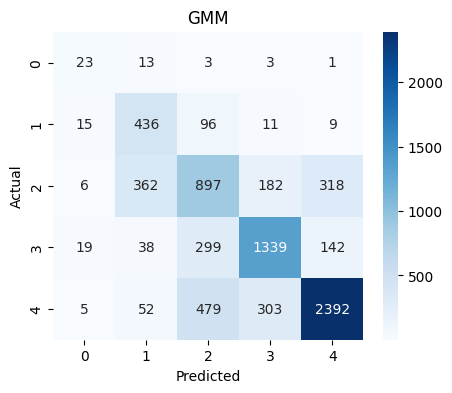

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat = model.conf_matrix(X_val, y_val)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.title("GMM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

CLass 0 and 1 are overpredicted. In general, a lot of confusion in the classification of all classes.

#### One-hot encoding
We will try if using one-hot encoding results any better.

In [6]:
X_train, X_test, y_train, y_test = utils.preprocessing_HOS(df)
X_train.head()

,carat,depth,table,price,x,y,z,color_D,color_E,color_F,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.891252,-2.238882,1.376095,0.938788,0.995677,1.110974,0.781410,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,-0.655872,-1.030724,-0.116047,-0.594611,-0.559529,-0.515909,-0.624511,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,-0.324346,-1.030724,1.873476,-0.522125,-0.051495,-0.265619,-0.222819,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,0.090063,-0.101371,-1.110808,-0.067156,0.332123,0.307962,0.312770,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1.416170,-0.658983,-1.110808,1.412649,1.400031,1.382121,1.300262,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [11]:
param_grid = {
	"covariance_type": ["full", "tied", "diag", "spherical"],
	"init_params": ["kmeans", "random", "random_from_data"],
}

grid_search = GridSearchCV(GMM(n_components=5, max_iter=200, n_init=5), param_grid, cv=5, scoring="accuracy",
							   return_train_score=True, verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=<src.gmm.GMM object at 0x000001A9E33F1A30>,
             n_jobs=-1,
             param_grid={'covariance_type': ['full', 'tied', 'diag',
                                             'spherical'],
                         'init_params': ['kmeans', 'random',
                                         'random_from_data']},
             return_train_score=True, scoring='accuracy', verbose=10)

In [12]:
sorted(zip(grid_search.cv_results_["mean_test_score"], grid_search.cv_results_["params"]), reverse=True, key=lambda x: x[0])

[(0.6124324666066495,
  {'covariance_type': 'spherical', 'init_params': 'random_from_data'}),
 (0.6118485426114789,
  {'covariance_type': 'spherical', 'init_params': 'kmeans'}),
 (0.6079470292210308,
  {'covariance_type': 'spherical', 'init_params': 'random'}),
 (0.4903376986659566, {'covariance_type': 'tied', 'init_params': 'random'}),
 (0.41625793360636915, {'covariance_type': 'tied', 'init_params': 'kmeans'}),
 (0.39587196409677694, {'covariance_type': 'full', 'init_params': 'kmeans'}),
 (0.384196890096746, {'covariance_type': 'full', 'init_params': 'random'}),
 (0.35980215822270306,
  {'covariance_type': 'full', 'init_params': 'random_from_data'}),
 (0.33190946495969975, {'covariance_type': 'diag', 'init_params': 'kmeans'}),
 (0.2762020021217334,
  {'covariance_type': 'tied', 'init_params': 'random_from_data'}),
 (0.24320599763030834,
  {'covariance_type': 'diag', 'init_params': 'random_from_data'}),
 (0.2121768900122148, {'covariance_type': 'diag', 'init_params': 'random'})]

In [13]:
param_grid = {
	"n_components": [1, 5, 10, 15, 20]
}

grid_search = GridSearchCV(GMM(covariance_type="spherical",max_iter=200, n_init=5, init_params="random"),
							   param_grid, cv=5, scoring="accuracy",
							   return_train_score=True, verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=<src.gmm.GMM object at 0x000001A9CA1C3F40>,
             n_jobs=-1, param_grid={'n_components': [1, 5, 10, 15, 20]},
             return_train_score=True, scoring='accuracy', verbose=10)

In [14]:
sorted(zip(grid_search.cv_results_["mean_test_score"], grid_search.cv_results_["params"]), reverse=True, key=lambda x: x[0])

[(0.6243233100449848, {'n_components': 10}),
 (0.6236330986183374, {'n_components': 20}),
 (0.6203153577713065, {'n_components': 15}),
 (0.6079470292210308, {'n_components': 5}),
 (0.4627615219562776, {'n_components': 1})]

In [7]:
model = GMM(n_components=10, max_iter=200, n_init=5, covariance_type="spherical", init_params="random_from_data")
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model.fit(X_train2, y_train2)
model.compute_metrics(X_val, y_val)

{'accuracy': 0.6217922880558915,
 'precision': 0.47577626318024857,
 'recall': 0.6027150264486213,
 'f1': 0.5040410811041653}

One-hot encoding didn't give better results. As an observation, the recall is much higher than the precision, similarly to label encoding.

Thus, we will stay with label encoding as preprocessing.

### With outliers

In [5]:
X_train, X_test, y_train, y_test = utils.preprocessing_LS(df)
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

param_grid = {
	"n_components": list(range(8, 16))
}

random_search = RandomizedSearchCV(GMM(max_iter=200, n_init=5, init_params="random"), param_grid, cv=5, 
						   scoring="accuracy", return_train_score=True, n_jobs=-1, n_iter=4)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=<src.gmm.GMM object at 0x000001CA5F38C5B0>,
                   n_iter=4, n_jobs=-1,
                   param_distributions={'n_components': [8, 9, 10, 11, 12, 13,
                                                         14, 15]},
                   return_train_score=True, scoring='accuracy')

In [6]:
sorted(zip(random_search.cv_results_["mean_test_score"], random_search.cv_results_["params"]), reverse=True)

[(0.6934556013765357, {'n_components': 13}),
 (0.6925055054317262, {'n_components': 10}),
 (0.688172282589652, {'n_components': 15}),
 (0.675310646242297, {'n_components': 9})]

10 is still the best value for `n_components` if we also take into account computational resources and speed.

In [9]:
model = GMM(n_components=10, max_iter=200, n_init=5, init_params="random")
model.fit(X_train2, y_train2)
model.compute_metrics(X_val, y_val)

{'accuracy': 0.6875217240180744,
 'precision': 0.6376768837689252,
 'recall': 0.6848836554628087,
 'f1': 0.6571779934251459}

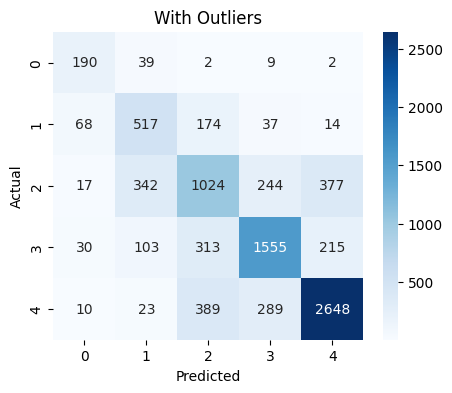

In [10]:
conf_mat = model.conf_matrix(X_val, y_val)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.title("With Outliers")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The performance of the model increased with the presence of outliers. We will keep them.

### Final test

In [4]:
X_train, X_test, y_train, y_test = utils.preprocessing_LS(df)
model = GMM(n_components=10, max_iter=200, n_init=5, covariance_type="full", init_params="random")
model.fit(X_train, y_train)
model.compute_metrics(X_test, y_test)

{'accuracy': 0.6832591768631813,
 'precision': 0.6299519941919024,
 'recall': 0.6811613944669193,
 'f1': 0.650901386481077}

Effectively, the model achieved similar metrics this time, as with the validation set. 

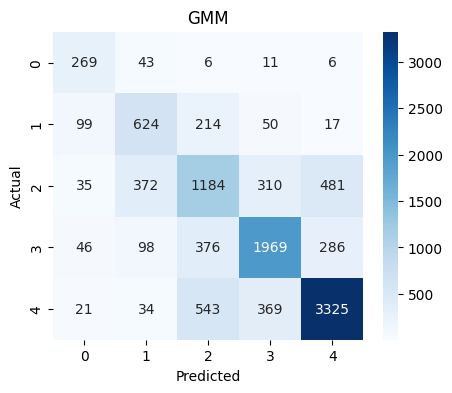

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat = model.conf_matrix(X_test, y_test)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.title("GMM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

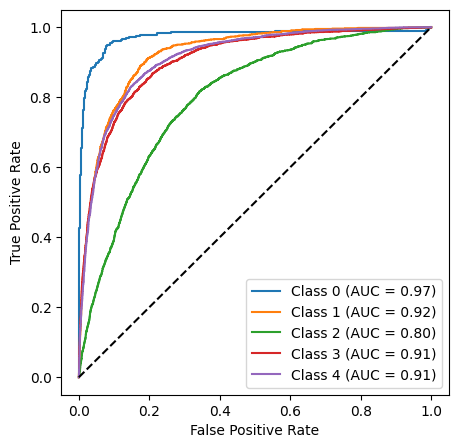

In [7]:
model.roc_curve(X_test, y_test)

GMM, like all previous models, also struggles with class 2, and it has a particulary low precision.